## K-Means - Create NYC Neighborhood Proxies
### University of Virginia
### DS 5110: Big Data Systems
### By: TeamBike

In [232]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local") \
    .appName("data preprocessing") \
    .config("spark.executor.memory", '8g') \
    .config('spark.executor.cores', '4') \
    .config('spark.cores.max', '4') \
    .config("spark.driver.memory",'8g') \
    .getOrCreate()

sc = spark.sparkContext

Read CSV I pulled from Abby's file; contains station info (lats, longs, address, etc.)

In [233]:
df = spark.read.csv('stations_master.csv', header=True, inferSchema=True)

Remove Manhattan and Brooklyn from the DF. I want to keep these boroughs unclustered. Set to no_mb. Rename columns. 

I am also adding a dummy `prediction` column with 999. I do not want these boroughs clustered, so anything here that's not 0-3 (so we don't step on Manhattan's or BK's clusters later) will do. This makes the union easier later.

In [234]:
from pyspark.sql.functions import lit
no_mb = df.where(df.Borough != 'Manhattan').where(df.Borough != 'Brooklyn')\
.withColumn("prediction", lit(999)).withColumnRenamed('startStationLatitude', 'latitude').withColumnRenamed('startStationLongitude', 'longitude')

Create a DF that's only Brooklyn (I want to cluster Manhattan and Brooklyn individually)

In [235]:
df_brook = df.where(df.Borough=='Brooklyn').withColumnRenamed('startStationLatitude', 'latitude').withColumnRenamed('startStationLongitude', 'longitude')

Repeat for Manhattan

In [236]:
df = df.where(df.Borough=='Manhattan').withColumnRenamed('startStationLatitude', 'latitude').withColumnRenamed('startStationLongitude', 'longitude')

Check to make sure this all worked

In [237]:
no_mb.show(5)

+---+-------+--------------------+------------------+----------+----------+
|_c0|Borough|    startStationName|          latitude| longitude|prediction|
+---+-------+--------------------+------------------+----------+----------+
|  3|  Bronx|Grand Concourse &...|         40.839549|-73.913004|       999|
| 12|  Bronx|E 170 St & Webste...|         40.836103|-73.907199|       999|
| 19| Queens|31 St & Astoria Blvd|         40.769917|-73.918405|       999|
| 23| Queens|      43 St & 23 Ave|         40.769673|-73.906018|       999|
| 25| Queens|  31 St & Hoyt Ave N|40.771153000000005|-73.917007|       999|
+---+-------+--------------------+------------------+----------+----------+
only showing top 5 rows



In [238]:
no_mb.groupby(no_mb.Borough).count().show()

+-------+-----+
|Borough|count|
+-------+-----+
| Queens|  296|
|  Bronx|  242|
+-------+-----+



In [239]:
df_brook.show(5)

+---+--------+--------------------+------------------+------------+
|_c0| Borough|    startStationName|          latitude|   longitude|
+---+--------+--------------------+------------------+------------+
|  2|Brooklyn|DeKalb Ave & Vand...|       40.68940747|-73.96885458|
| 16|Brooklyn|Pacific St & Nevi...|         40.685376|  -73.983021|
| 20|Brooklyn|Pioneer St & Rich...|         40.677775|  -74.009461|
| 21|Brooklyn|       10 St & 7 Ave|40.666208000000005|  -73.981999|
| 22|Brooklyn|Henry St & Atlant...|         40.690892|  -73.996123|
+---+--------+--------------------+------------------+------------+
only showing top 5 rows



In [240]:
df_brook.groupby(df_brook.Borough).count().show()

+--------+-----+
| Borough|count|
+--------+-----+
|Brooklyn|  914|
+--------+-----+



In [241]:
df.groupby(df.Borough).count().show()

+---------+-----+
|  Borough|count|
+---------+-----+
|Manhattan| 1419|
+---------+-----+



Get data assembled and transformed for Manhattan:

In [242]:
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(df)
new_df.show(5)

+---+---------+--------------------+-----------+------------+--------------------+
|_c0|  Borough|    startStationName|   latitude|   longitude|            features|
+---+---------+--------------------+-----------+------------+--------------------+
|  0|Manhattan|Frederick Douglas...|  40.801694|  -73.957145|[40.801694,-73.95...|
|  1|Manhattan|     W 44 St & 5 Ave|40.75500254|-73.98014437|[40.75500254,-73....|
|  4|Manhattan|     E 43 St & 5 Ave|     40.755|      -73.98|     [40.755,-73.98]|
|  5|Manhattan|     E 12 St & 3 Ave|  40.732232|  -73.988899|[40.732232,-73.98...|
|  6|Manhattan|Grand St & Greene St|    40.7217|  -74.002381|[40.7217,-74.002381]|
+---+---------+--------------------+-----------+------------+--------------------+
only showing top 5 rows



In [243]:
new_brook = vecAssembler.transform(df_brook)
new_brook.show(5)

+---+--------+--------------------+------------------+------------+--------------------+
|_c0| Borough|    startStationName|          latitude|   longitude|            features|
+---+--------+--------------------+------------------+------------+--------------------+
|  2|Brooklyn|DeKalb Ave & Vand...|       40.68940747|-73.96885458|[40.68940747,-73....|
| 16|Brooklyn|Pacific St & Nevi...|         40.685376|  -73.983021|[40.685376,-73.98...|
| 20|Brooklyn|Pioneer St & Rich...|         40.677775|  -74.009461|[40.677775,-74.00...|
| 21|Brooklyn|       10 St & 7 Ave|40.666208000000005|  -73.981999|[40.6662080000000...|
| 22|Brooklyn|Henry St & Atlant...|         40.690892|  -73.996123|[40.690892,-73.99...|
+---+--------+--------------------+------------------+------------+--------------------+
only showing top 5 rows



Run K-Means on Manhattan with 4 clusters

In [244]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=4, seed=1)  # 4 clusters here
model = kmeans.fit(new_df.select('features'))

In [245]:
transformed = model.transform(new_df)
#transformed.show()

In [246]:
transformed = transformed.select([x for x in transformed.columns if x != 'features']) # remove features so I can union back to the OG data w just Queens and the Bronx

In [247]:
#transformed.show()

In [248]:
#no_manhattan.show()

I want 2 clusters for Brooklyn. Repeat clustering with k = 2 on Brooklyn data:

In [249]:
kmeans = KMeans(k=2, seed=1)  # 2 clusters here
model = kmeans.fit(new_brook.select('features'))
transformed_brook = model.transform(new_brook)

In [250]:
transformed.show(5)

+---+---------+--------------------+-----------+------------+----------+
|_c0|  Borough|    startStationName|   latitude|   longitude|prediction|
+---+---------+--------------------+-----------+------------+----------+
|  0|Manhattan|Frederick Douglas...|  40.801694|  -73.957145|         1|
|  1|Manhattan|     W 44 St & 5 Ave|40.75500254|-73.98014437|         0|
|  4|Manhattan|     E 43 St & 5 Ave|     40.755|      -73.98|         0|
|  5|Manhattan|     E 12 St & 3 Ave|  40.732232|  -73.988899|         3|
|  6|Manhattan|Grand St & Greene St|    40.7217|  -74.002381|         3|
+---+---------+--------------------+-----------+------------+----------+
only showing top 5 rows



In [251]:
transformed_brook = transformed_brook.select([x for x in transformed_brook.columns if x != 'features']) # remove features so I can union back to the OG data w just Queens and the Bronx

In [252]:
transformed_brook.show(5)

+---+--------+--------------------+------------------+------------+----------+
|_c0| Borough|    startStationName|          latitude|   longitude|prediction|
+---+--------+--------------------+------------------+------------+----------+
|  2|Brooklyn|DeKalb Ave & Vand...|       40.68940747|-73.96885458|         0|
| 16|Brooklyn|Pacific St & Nevi...|         40.685376|  -73.983021|         0|
| 20|Brooklyn|Pioneer St & Rich...|         40.677775|  -74.009461|         0|
| 21|Brooklyn|       10 St & 7 Ave|40.666208000000005|  -73.981999|         0|
| 22|Brooklyn|Henry St & Atlant...|         40.690892|  -73.996123|         0|
+---+--------+--------------------+------------------+------------+----------+
only showing top 5 rows



Union all three DFs back together:

In [253]:
df_fin = no_mb.union(transformed).union(transformed_brook)

In [254]:
df_fin.show(5)

+---+-------+--------------------+------------------+----------+----------+
|_c0|Borough|    startStationName|          latitude| longitude|prediction|
+---+-------+--------------------+------------------+----------+----------+
|  3|  Bronx|Grand Concourse &...|         40.839549|-73.913004|       999|
| 12|  Bronx|E 170 St & Webste...|         40.836103|-73.907199|       999|
| 19| Queens|31 St & Astoria Blvd|         40.769917|-73.918405|       999|
| 23| Queens|      43 St & 23 Ave|         40.769673|-73.906018|       999|
| 25| Queens|  31 St & Hoyt Ave N|40.771153000000005|-73.917007|       999|
+---+-------+--------------------+------------------+----------+----------+
only showing top 5 rows



Some checks. Data are roughly balanced, or at least better than before -- and more mathematically neighborhoody:

In [255]:
from pyspark.sql import functions as F
df_fin.groupby('Borough', 'prediction').agg(F.count('prediction')).show()

+---------+----------+-----------------+
|  Borough|prediction|count(prediction)|
+---------+----------+-----------------+
|    Bronx|       999|              242|
|Manhattan|         3|              514|
| Brooklyn|         0|              540|
| Brooklyn|         1|              374|
|Manhattan|         0|              447|
|Manhattan|         1|              357|
|Manhattan|         2|              101|
|   Queens|       999|              296|
+---------+----------+-----------------+



In [256]:
df_fin.count() # count matches back to the original data

2871

Concatenate to create the new neighborhoods. Give the name as `concat` to be boring:

In [257]:
from pyspark.sql.functions import concat
df_fin = df_fin.withColumn('concat',concat(*['Borough', 'prediction']))

In [258]:
df_fin.show(5)

+---+-------+--------------------+------------------+----------+----------+---------+
|_c0|Borough|    startStationName|          latitude| longitude|prediction|   concat|
+---+-------+--------------------+------------------+----------+----------+---------+
|  3|  Bronx|Grand Concourse &...|         40.839549|-73.913004|       999| Bronx999|
| 12|  Bronx|E 170 St & Webste...|         40.836103|-73.907199|       999| Bronx999|
| 19| Queens|31 St & Astoria Blvd|         40.769917|-73.918405|       999|Queens999|
| 23| Queens|      43 St & 23 Ave|         40.769673|-73.906018|       999|Queens999|
| 25| Queens|  31 St & Hoyt Ave N|40.771153000000005|-73.917007|       999|Queens999|
+---+-------+--------------------+------------------+----------+----------+---------+
only showing top 5 rows



Send to pandas. Need in pandas form for graphing:

In [259]:
df_p = df_fin.toPandas()

In [260]:
df_p

,_c0,Borough,startStationName,latitude,longitude,prediction,concat
0,3,Bronx,Grand Concourse & E 171 St,40.839549,-73.913004,999,Bronx999
1,12,Bronx,E 170 St & Webster Ave,40.836103,-73.907199,999,Bronx999
2,19,Queens,31 St & Astoria Blvd,40.769917,-73.918405,999,Queens999
3,23,Queens,43 St & 23 Ave,40.769673,-73.906018,999,Queens999
4,25,Queens,31 St & Hoyt Ave N,40.771153,-73.917007,999,Queens999
...,...,...,...,...,...,...,...
2866,2860,Brooklyn,Myrtle Ave & Marcy Ave,40.695000,-73.950000,1,Brooklyn1
2867,2865,Brooklyn,Graham Ave & Herbert St,40.719293,-73.945003,1,Brooklyn1
2868,2867,Brooklyn,Court St & State St,40.690238,-73.992031,0,Brooklyn0
2869,2868,Brooklyn,Church Ave & McDonald Ave,40.642809,-73.979239,0,Brooklyn0


In [261]:
#df_p.to_csv('boroughs2.csv')

Plot:

In [262]:
import plotly.express as px

In [263]:
fig = px.scatter(df_p, x = 'longitude', y = 'latitude', color='concat',
                 hover_data=['concat'], height=800)

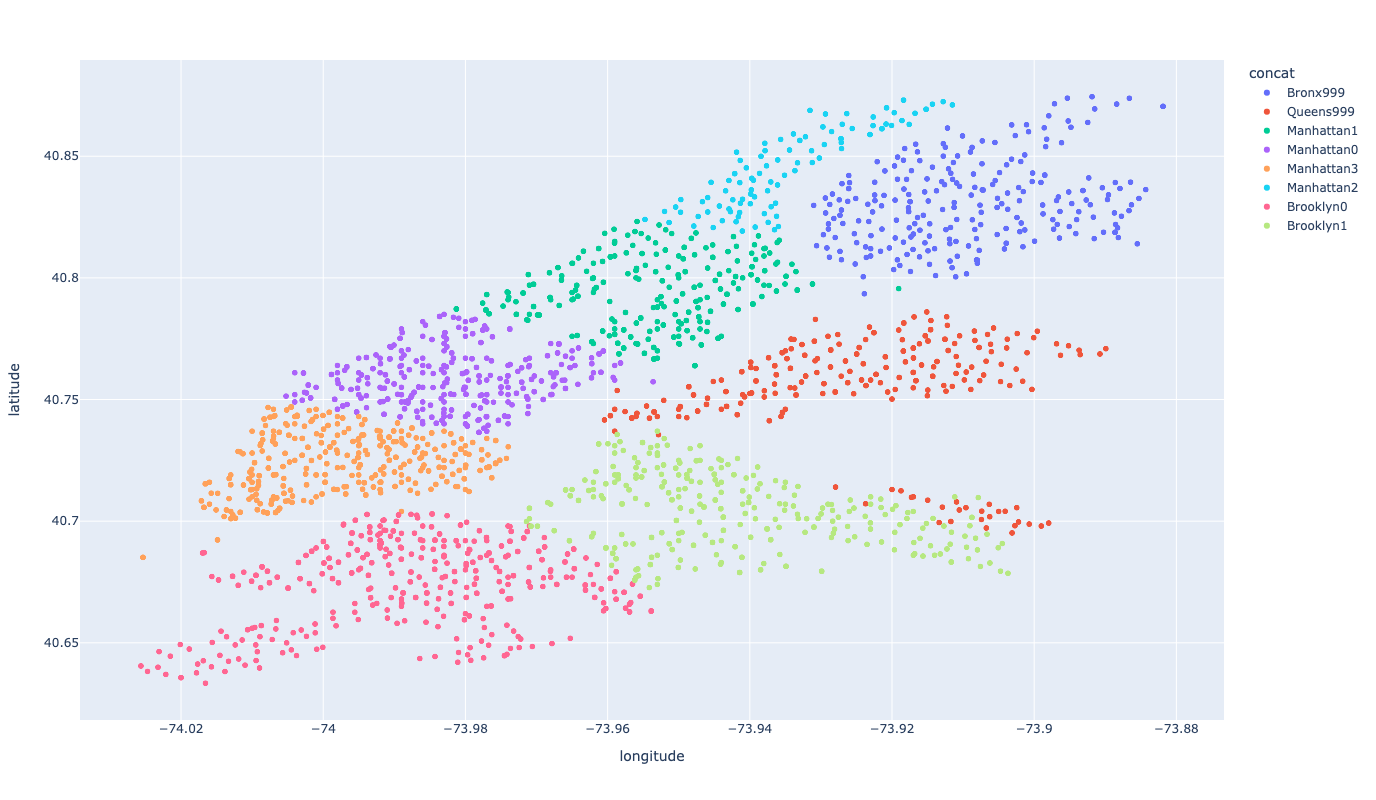

In [264]:
fig.show()

In [265]:
df_p.count()

_c0                 2871
Borough             2871
startStationName    2871
latitude            2871
longitude           2871
prediction          2871
concat              2871
dtype: int64

In [266]:
df_p.to_csv('station_df.csv')